In [2]:
from gpt import GPTModel
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset,DataLoader

In [2]:
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":256,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [4]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
    """
    model - GPT model
    idx - token ids of the input 
    max_new_tokens - maximum number of tokens that need to be generated
    context_size -maximum number of tokens that model can generated
    
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] #selects last columns of number context length
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:,-1,:] #3D tensor. extract last sequence from each batch
        probas = torch.softmax(logits,dim=-1)
        idx_next = torch.argmax(probas,dim=-1,keepdim=True)
        idx = torch.cat((idx,idx_next),dim=-1) #concatonate tensors in last dimension
        
    return idx

In [5]:
def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)   
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


In [6]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context,tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
    )

print("output text \n:",token_ids_to_text(token_ids,tokenizer))

output text 
: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                        [40,    1107, 588]])   #  "I really like"]
    
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                    [1107, 588, 11311]])  #  " really like chocolate"]

In [8]:
with torch.no_grad():
    logits =  model(inputs)
probas = torch.softmax(logits,dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [9]:
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print("Token IDS:\n",token_ids)
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Token IDS:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1: Armed heNetflix


In [10]:
#find initial softmax probability scores corresponding to target tokens
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 1:",target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 1:",target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 1: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [11]:
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [12]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [13]:
#cross entropy
neg_avg_log_probas = avg_log_probas * -1

In [14]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)


Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [15]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7940)


## Calculating training and validation loses

In [17]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:",total_characters)
print("Tokens:",total_tokens)

Characters: 20479
Tokens: 5145


In [19]:
train_ratio = 0.90
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [20]:
class GPTDatasetV1(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt)
        
        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx],self.target_ids[idx]

In [21]:
def create_dataloader_v1(txt,batch_size=4,max_length=256,
                      stride=128,shuffle=True,drop_last=True,
                      num_workers=0):
    
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    
    return dataloader

In [22]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
 )
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
 )

In [23]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [24]:
def calc_loss_batch(input_batch,target_batch,model,devises):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()
    )
    return loss

In [25]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            total_loss += loss.item()
            
        else:
            break
    return total_loss/num_batches
    

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758316040039
Validation loss: 10.981106758117676


# Training LLM

In [27]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval() #set modl to evaluation mode
    with torch.no_grad(): #dissbale gradient calculation
        train_loss = calc_loss_loader(
             train_loader,model,device,num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader,model,device,num_batches=eval_iter
        )
        model.train()#set the model back to training mode
        return train_loss,val_loss

In [28]:
def generate_and_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [29]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
    train_losses, val_losses,track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0,-1
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (step{global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                     )
                generate_and_print_sample(
                    model, tokenizer, device, start_context
                )
                
    return train_losses,val_losses,track_tokens_seen

In [30]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,weight_decay=0.1
)
num_epochs = 10
train_losses,val_losses,tokens_seen = train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,
    start_context="Every effort moves you",tokenizer=tokenizer
)

Ep 1 (step000000): Train loss 9.783, Val loss 9.927
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 1 (step000005): Train loss 7.985, Val loss 8.335
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (step000010): Train loss 6.753, Val loss 7.048
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (step000015): Train loss 6.114, Val loss 6.573
Every effort moves you, the to the to the.                                           
Ep 3 (step000020): Train loss 5.525, Val loss 6.490
Every effort moves you, and, and the of the of the of the of the of the of the of the of the of the of the of the of the the of the the of the of the of the of the of the of the of the of the of
Ep 3 (step000025): Train loss 5.324, Val loss 6.387
Every effort moves you his " to the pi

## Stratergies to control randomness

In [31]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Temperature samplelling

In [32]:
vocab = {
    "closer":0,
    "every":1,
    "effort":2,
    "forward":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8,
}
inverse_vocab = {v: k for k,v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits,dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [33]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas,num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [34]:
#function to repeat the sampling 1000 times
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas,num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
        
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [35]:
#temperature scaling
def softmax_with_temperature(logits,temperature):
    scaled_logits = logits/temperature
    return torch.softmax(scaled_logits,dim=0)

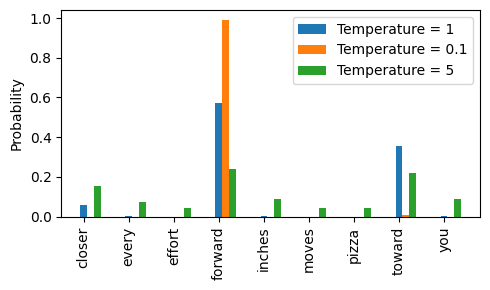

In [36]:
import matplotlib.pyplot as plt

temperatures =[1,0.1,5]
scaled_probas = [softmax_with_temperature(next_token_logits,T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig,ax = plt.subplots(figsize=(5,3))
for i,T in enumerate(temperatures):
    rects = ax.bar(x+i * bar_width, scaled_probas[i],bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [37]:
top_k = 3
top_logits,top_pos = torch.topk(next_token_logits,top_k)
print("Top logits: ",top_logits)
print("Top positions: ",top_pos)

Top logits:  tensor([6.7500, 6.2800, 4.5100])
Top positions:  tensor([3, 7, 0])


In [38]:
new_logits = torch.where(condition=next_token_logits<top_logits[-1],
                        input=torch.tensor(float('-inf')),
                        other=next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [39]:
topk_probas = torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [40]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)  
        logits = logits[:,-1,:]
        
        if top_k is not None:
            top_logits,_ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits<min_val,torch.tensor(float('-inf')).to(logits.device),logits)
            
        if temperature > 0.0:
            logits = logits/temperature
            probas = torch.softmax(logits,dim=-1)
            idx_next = torch.argmax(probas,dim=-1,keepdim=True)
        else:
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx,idx_next),dim=1)
        
    return idx

In [41]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 20,
    temperature=0.5
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted


## Saving trained model

In [43]:
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [44]:
#loading saved weights and optimizer states to restore model
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-4,weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

C:\Users\User\AppData\Local\Temp\ipykernel_13232\3546596963.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth",map_locatio

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features